# unsupervised learning of features in a video database

In [109]:
import tensorflow as tf
import sklearn.preprocessing as pre
import numpy as np
import time
from math import ceil
from dataclasses import dataclass

@dataclass
class Batcher:
    batch_size: int
    X_train: np.array
    y_train: np.array
    X_test: np.array
    y_test: np.array
        
    def train_batch(self):
        train_ds = \
            tf.data.Dataset.from_tensor_slices(
                (self.X_train, self.y_train)
            ).shuffle(10000).batch(batch_size=self.batch_size, drop_remainder=False)
        return train_ds
    
    def test_batch(self):
        test_ds = \
            tf.data.Dataset.from_tensor_slices(
                (self.X_test, self.y_test)
            ).batch(batch_size=self.batch_size, drop_remainder=False)
        return test_ds
    
    def num_train_batches(self):
        return int(ceil(self.X_train.shape[0] / self.batch_size))
    
    def num_test_batches(self):
        return int(ceil(self.X_test.shape[0] / self.batch_size))
    
def early_stopping_check(epoch, train_history, min_delta, patience_count,
                         patience):
    if epoch > 1 and train_history[-2][-2] - train_history[-1][-2] \
            > min_delta:
        patience_count = 0
    else:
        patience_count += 1

    return patience_count, (patience_count > patience)
    
@dataclass
class Trainer:
    """Binds a model, databunch, and config for training purposes.
  
      Ideally Dash app can work with this object without reference to
      underlying model
      type.
      """

    model: tf.keras.models.Model
    batcher: Batcher
    optimizer: tf.keras.optimizers.Optimizer = tf.keras.optimizers.Adam
    loss_function: tf.keras.metrics.Metric = tf.keras.losses.BinaryCrossentropy
    batch_size: int = 128
    num_epochs: int = 25

    def __post_init__(self):
        self.optimizer = self.optimizer()
        self.loss_function = self.loss_function()
        self.train_loss = tf.keras.metrics.BinaryCrossentropy(name='train_loss')
        self.test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')

        self.train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
        self.test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

        self.train_auc = tf.keras.metrics.AUC(name='train_auc', num_thresholds=1000)
        self.test_auc = tf.keras.metrics.AUC(name='train_auc', num_thresholds=1000)

        self.trained = False

    def __eq__(self, other):
        if isinstance(other, type(self)):
            return ((self.model, self.loss_function, self.optimizer,
                     self.train_loss, self.train_accuracy, self.train_auc,
                     self.test_loss, self.test_accuracy, self.test_auc) ==
                    (other.model, other.loss_function, other.optimizer,
                     other.train_loss, other.train_accuracy, other.train_auc,
                     other.test_loss, other.test_accuracy, other.test_auc))
        return NotImplemented

    def __hash__(self):
        return (hash(self.model) ^ hash(self.loss_function) ^ hash(self.optimizer)
                ^ hash(self.train_loss) ^ hash(self.train_accuracy) ^
                hash(self.train_auc) ^ hash(self.test_loss) ^
                hash(self.test_accuracy) ^ hash(self.test_auc) ^
                hash((self.model, self.loss_function, self.optimizer,
                      self.train_loss, self.train_accuracy, self.train_auc,
                      self.test_loss, self.test_accuracy, self.test_auc)))

    @tf.function
    def train_step(self, observations, labels):
        with tf.GradientTape() as tape:
            predictions = self.model(observations)
            loss = self.loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,
                                           self.model.trainable_variables))

    @tf.function
    def test_step(self, observations, labels):
        predictions = self.model(observations)

    def reset_states(self):
        self.train_loss.reset_states()
        self.train_accuracy.reset_states()
        self.test_loss.reset_states()
        self.test_accuracy.reset_states()

    def fit(self):
        # transforms = get_transforms_from_config(self.config)
        if self.trained:
            metrics_dict = {
                'Train Loss': self.train_loss.result().numpy(),
                'Train Accuracy': self.train_accuracy.result().numpy()}
            return metrics_dict

        train_batched = self.batcher.train_batch()
        test_batched = self.batcher.test_batch()

        train_history = []
        patience_count = 0

        for epoch in range(self.num_epochs):
            print(f'{epoch+1} / {self.num_epochs}')
            self.reset_states()

            for i, (observations, labels) in enumerate(train_batched):
                prev_time = time.time()
                self.train_step(observations, labels)
                duration = time.time() - prev_time
                print(f'\t{i+1} / {self.batcher.num_train_batches()} ({duration:.2f})s')

            for test_observations, test_labels in test_batched:
                self.test_step(test_observations, test_labels)

        self.trained = True
        return self.model

    def eval(self):
        self.reset_states()
        _, test_batch = self.batcher.test_batch(self.batch_size)
        for observations, labels in test_batch:
            self.test_step(observations, labels)

        metrics_dict = dict(test_loss=self.test_loss.result().numpy(),
                            test_accuracy=self.test_accuracy.result().numpy(),
                            test_auc=self.test_auc.result().numpy())
        return metrics_dict


## ResNet autoencoder

In [64]:
# example of a CNN model with an identity or projection residual module
%load_ext autoreload
%autoreload 2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, add, UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
 
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [67]:
# define model input
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (2,2), padding='same', activation='relu', kernel_initializer='he_normal')(input_img)
x = residual_module(x, 8)
x = residual_module(x, 16)
x = residual_module(x, 32)
x = residual_module(x, 64)
x = AveragePooling2D((2, 2))(x)

x = UpSampling2D((2, 2))(x)
x = residual_module(x, 64)
x = residual_module(x, 32)
x = residual_module(x, 16)
x = residual_module(x, 8)
x = Conv2D(1, (2,2), padding='same', activation='relu', kernel_initializer='he_normal')(x)


autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#autoencoder.summary()

In [110]:
batcher = Batcher(128, X_train, X_train, X_test, X_test)
trainer = Trainer(autoencoder, batcher, num_epochs=1)
trainer.fit()

1 / 1
	1 / 469 (2.57)s
	2 / 469 (1.34)s
	3 / 469 (1.26)s
	4 / 469 (1.25)s
	5 / 469 (1.32)s
	6 / 469 (1.33)s
	7 / 469 (1.29)s
	8 / 469 (1.25)s


KeyboardInterrupt: 

In [100]:
autoencoder.fit(X_train, X_train, batch_size=1024, epochs=1, verbose=1)

Train on 60000 samples
 1024/60000 [..............................] - ETA: 9:55

KeyboardInterrupt: 

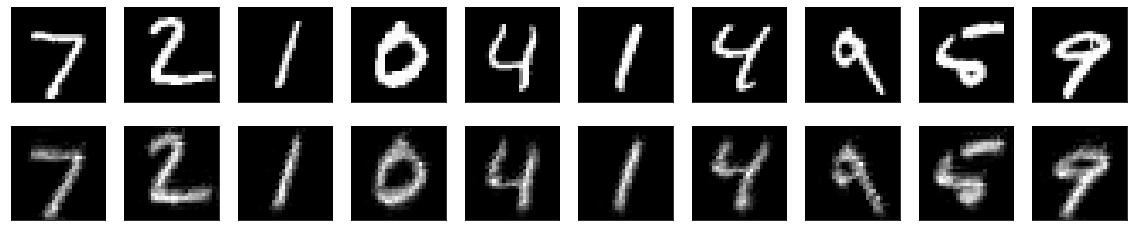

In [23]:
%matplotlib inline
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()